# Pre/post landfall comparison
In which we compare the difference in anchor information before and after hurricane landfall among individual user accounts.

Goals:

- Compare anchor proportions before/after landfall per-entity after matching on user info
- Compare anchor proportions before/after landfall per-user after matching on entity info

TODO: is this comparison redundant?

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Load data

In [2]:
import dateutil
from importlib import reload
import re

def fix_username(data):
    data = data.assign(**{'username' : data.loc[:, 'username'].apply(lambda x: x.split(':')[-1])})
    RT_MATCHER = re.compile('(?<=RT @)[A-Za-z0-9_]+(?=:)')
    data = data.assign(**{'username_rt' : data.loc[:, 'txt'].apply(lambda x: RT_MATCHER.search(x).group(0) if RT_MATCHER.search(x) is not None else '')})
    ## fix usernames
    data = data.assign(**{'username_fixed' : data.apply(lambda x: x.loc['username_rt'] if x.loc['username_rt'] != '' else x.loc['username'], axis=1)})
    return data

## load full data for user activity counts
data_file = '../../data/mined_tweets/combined_tweet_tag_data_NE_flat.gz'
dep_var = 'max_population_anchor'
combined_data_full = pd.read_csv(data_file, sep='\t', index_col=False, compression='gzip', converters={'date': dateutil.parser.parse})
## add username fixed
combined_data_full = fix_username(combined_data_full)

In [3]:
## load basic data
import predict_descriptor_in_twitter
reload(predict_descriptor_in_twitter)
from predict_descriptor_in_twitter import load_clean_data
# include all NEs for completeness
top_k_NE_min = -1
combined_data = load_clean_data(data_file, top_k_NE_min=top_k_NE_min, dep_var = 'max_population_anchor')

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [4]:
## compute activity count for all users in full data
def add_user_activity_count(data, group_var='data_name_fixed', user_var='username_fixed', activity_var='user_activity', N_bins=5):
    data_activity = []
    for data_name_i, data_i in data.groupby(group_var):
#         print(data_i.loc[:, user_var].value_counts())
        user_counts_i = pd.DataFrame(data_i.loc[:, user_var].value_counts()).reset_index().rename(columns={'index':user_var, user_var:activity_var})
#         print(user_counts_i)
        ## log-transform, bin
        user_counts_i = user_counts_i.assign(**{activity_var : np.log(user_counts_i.loc[:, activity_var])})
        bins_i = np.linspace(user_counts_i.loc[:, activity_var].min(), user_counts_i.loc[:, activity_var].max(), N_bins)
        data_bins_i = np.digitize(user_counts_i.loc[:, activity_var], bins=bins_i, right=False)
        user_counts_i = user_counts_i.assign(**{'%s_bin'%(activity_var) : data_bins_i})
        data_i = pd.merge(data_i, user_counts_i, on=[user_var], how='inner')
        data_activity.append(data_i)
    data_activity = pd.concat(data_activity, axis=0)
    return data_activity
combined_data_full_ = add_user_activity_count(combined_data_full)
## transfer to regular combined data
combined_data_full_user_activity = combined_data_full_.loc[:, ['username_fixed', 'user_activity', 'user_activity_bin', 'data_name_fixed']].drop_duplicates(inplace=False)
if('user_activity' in combined_data.columns):
    combined_data.drop(['user_activity', 'user_activity_bin'], axis=1, inplace=True)
combined_data = pd.merge(combined_data_full_user_activity, combined_data, on=['username_fixed', 'data_name_fixed'], how='right')

In [5]:
print(combined_data.shape[0])
display(combined_data[np.isnan(combined_data.loc[:, 'user_activity'].values)].head())
display(combined_data[np.isnan(combined_data.loc[:, 'user_activity'].values)].head().apply(lambda x: x.loc['username_rt'] if x.loc['username_rt'] != '' else x.loc['username'], axis=1))

158643


,username_fixed,user_activity,user_activity_bin,data_name_fixed,id,txt,username,date,lang,NE,...,landfall,since_form,since_landfall,since_dissipation,time_period_type,max_pop,max_names,max_pop_bin,max_names_bin,username_rt


,username_fixed,user_activity,user_activity_bin,data_name_fixed,id,txt,username,date,lang,NE,...,landfall,since_form,since_landfall,since_dissipation,time_period_type,max_pop,max_names,max_pop_bin,max_names_bin,username_rt


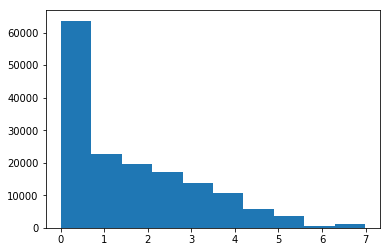

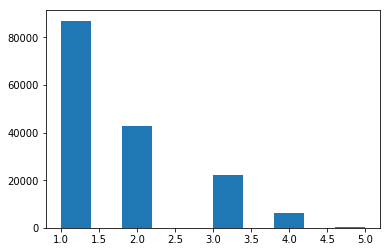

In [6]:
# user activity distribution
plt.hist(combined_data.loc[:, 'user_activity'])
plt.show()
plt.hist(combined_data.loc[:, 'user_activity_bin'])
plt.show()

In [7]:
## add followers/follower-ratio
from importlib import reload
import predict_descriptor_in_twitter
reload(predict_descriptor_in_twitter)
from predict_descriptor_in_twitter import add_user_data
combined_data_user = add_user_data(combined_data)

29227/76618 users covered
92461/158643 user data


What is the temporal distribution of data? We need a considerable number of pre-treatment samples, i.e. pre-landfall.

In [8]:
time_period_var = 'time_period_type'
combined_data_period_counts = combined_data_user.loc[:, time_period_var].value_counts()
display(combined_data_period_counts)

landfall       73700
dissipation    12249
form            6512
Name: time_period_type, dtype: int64

## Compare P(anchor) per entity

In [9]:
import datetime
## what is the distribution of NEs?
NE_var = 'NE_fixed'
time_period_i = 'landfall'
print(combined_data_user[combined_data_user.loc[:, time_period_var]==time_period_i].loc[:, NE_var].value_counts())

houston              10374
miami                 6222
naples                3208
san_juan              2849
tampa                 2734
orlando               1755
rockport              1484
marco_island          1408
atlanta                942
corpus_christi         939
jacksonville           911
panama_city            884
mexico_beach           838
miami_beach            746
charleston             632
tallahassee            613
wilmington             587
fort_myers             512
austin                 482
port_aransas           459
fort_lauderdale        445
sarasota               373
dallas                 354
port_arthur            339
anguilla               335
panhandle              331
broward_county         317
galveston              298
harris_county          276
palm_beach             275
                     ...  
dale                     1
alma                     1
hoboken                  1
mcconnell                1
pikeville                1
palm_aire                1
e

In [10]:
##  split before/after data
day_buffer = 3.
date_var = 'date'
time_period_diff_i = '%s_diff'%(time_period_i)
group_var = 'data_name_fixed'
combined_data_user = combined_data_user.assign(**{time_period_diff_i : (combined_data_user.loc[:, date_var].apply(datetime.datetime.fromtimestamp) - combined_data_user.loc[:, time_period_i]).apply(lambda x: x.days)})
## we want to treat each NE within each data set separately
NE_var = 'NE_fixed'
NE_data_var = '%s_data_name'%(NE_var)
combined_data_user = combined_data_user.assign(**{NE_data_var : combined_data_user.apply(lambda x: '%s_%s'%(x.loc[NE_var], x.loc[group_var]), axis=1)})
## split data before/after
combined_data_user_pre = combined_data_user[(combined_data_user.loc[:, time_period_diff_i] >= -day_buffer) &
                                            (combined_data_user.loc[:, time_period_diff_i] < 0.)]
combined_data_user_post = combined_data_user[(combined_data_user.loc[:, time_period_diff_i] <= day_buffer) &
                                             (combined_data_user.loc[:, time_period_diff_i] > 0.)]
NEs_before_after = set(combined_data_user_pre.loc[:, NE_data_var].unique()) & set(combined_data_user_post.loc[:, NE_data_var].unique())
print('%d treated units'%(len(NEs_before_after)))
# combined_data_user_pre_valid = combined_data_user_pre[combined_data_user_pre.loc[:, NE_data_var].isin(NEs_before_after)]
# combined_data_user_post_valid = combined_data_user_post[combined_data_user_post.loc[:, NE_data_var].isin(NEs_before_after)]

679 treated units


In [12]:
## get counts for later restriction?
NE_data_counts_pre = combined_data_user_pre.loc[:, NE_data_var].value_counts()
NE_data_counts_post = combined_data_user_post.loc[:, NE_data_var].value_counts()
min_NE_count = 3
NE_valid_pre = list(NE_data_counts_pre[NE_data_counts_pre >= min_NE_count].index)
NE_valid_post = list(NE_data_counts_post[NE_data_counts_post >= min_NE_count].index)
print('%d valid NEs before'%(len(NE_valid_pre)))
print('%d valid NEs after'%(len(NE_valid_post)))

294 valid NEs before
986 valid NEs after


Let's plot the raw treatment/control anchor proportion.

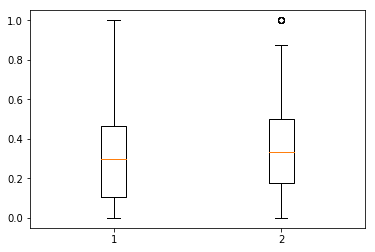

diff=0.020 test=11.827 p=2.820E-32


In [13]:
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import wilcoxon
NE_pre_post_shared = list(set(NE_valid_pre) & set(NE_valid_post))
dep_var = 'max_population_anchor'
pre_treatment = combined_data_user_pre.groupby(NE_data_var).apply(lambda x: x.loc[:, dep_var].sum() / x.shape[0])
post_treatment = combined_data_user_post.groupby(NE_data_var).apply(lambda x: x.loc[:, dep_var].sum() / x.shape[0])
pre_treatment = pre_treatment.loc[NE_pre_post_shared]
post_treatment = post_treatment.loc[NE_pre_post_shared]
plt.boxplot([pre_treatment, post_treatment])
plt.show()
test_stat, p_val = proportions_ztest([combined_data_user_pre.loc[:, dep_var].sum(), 
                                      combined_data_user_post.loc[:, dep_var].sum()], 
                                     [combined_data_user_pre.shape[0], 
                                      combined_data_user_post.shape[0]])
# test_stat, p_val = wilcoxon(pre_treatment, post_treatment)
effect_diff = (post_treatment - pre_treatment).median()
print('diff=%.3f test=%.3f p=%.3E'%(effect_diff, test_stat, p_val))

This difference is pretty small! But it seems to be significant. 

Let's back up and try the full NE set with the following specs:

entity | treat/control | importance | user activity | audience

### Causal inference
Try causal inference, using time (before/after event) as the treatment.

In [83]:
## using a local install
import sys
if('Causalinference' not in sys.path):
    sys.path.append('Causalinference')
from importlib import reload
import causalinference
reload(causalinference)
from causalinference import CausalModel
def compute_treatment_effect(data, treatment_var='landfall_treatment', control_vars=['max_pop_bin'], effect_var='max_population_anchor', verbose=False):
    """
    Compute treatment effect on samples
    with matching.
    """
    ## Y,D,X
    Y = data.loc[:, effect_var].values
    D = data.loc[:, treatment_var].values
    X = data.loc[:, control_vars].values
    model = CausalModel(Y, D, X)
    # summary stats
    if(verbose):
        print(model.summary_stats)
    # matching
    model.est_via_matching()
    # propensity
    model.est_propensity_s()
    # propensity + strata
    model.stratify_s()
    # OLS
    model.est_via_ols()
    return model

In [38]:
## set t-3 as control, t+3 as treatment
treatment_event = 'landfall'
treatment_diff_var = '%s_diff'%(treatment_event)
treatment_var = '%s_treatment'%(treatment_event)
effect_var = 'max_population_anchor'
date_buffer = 3.
date_var = 'date_day'
combined_data_user = combined_data_user.assign(**{treatment_diff_var : (combined_data_user.loc[:, date_var] - combined_data_user.loc[:, treatment_event]).apply(lambda x: x.days)})
combined_data_user_with_treat_control = combined_data_user[abs(combined_data_user.loc[:, treatment_diff_var]) <= date_buffer]
combined_data_user_with_treat_control = combined_data_user_with_treat_control.assign(**{treatment_var : (combined_data_user_with_treat_control.loc[:, treatment_diff_var] > 0.).astype(int)})
## set effect to int
combined_data_user_with_treat_control = combined_data_user_with_treat_control.assign(**{effect_var : combined_data_user_with_treat_control.loc[:, effect_var].astype(int)})
combined_data_user_with_treat_control = combined_data_user_with_treat_control.drop_duplicates(['id', 'NE_fixed_data_name'], inplace=False)

In [96]:
## save to file for posterity!!
combined_data_user_with_treat_control.to_csv('../../data/mined_tweets/combined_tweet_NE_landfall_treatment.tsv', sep='\t', index=False)

In [99]:
# control_vars = ['max_pop_bin', 'max_names_bin', 'user_activity', 'followers_log', 'followers_friends']
# control_vars = ['max_pop_bin', 'max_names_bin', 'user_activity_bin', 'followers_log', 'followers_friends']
# switch from bins -> raw
control_vars = ['max_population', 'max_alternate_name_count', 'user_activity', 'followers_log', 'followers_friends']
# compute summary stats before?
model_fit = compute_treatment_effect(combined_data_user_with_treat_control, treatment_var=treatment_var, control_vars=control_vars, effect_var=effect_var, verbose=False)
print(model_fit.summary_stats)
print(model_fit.estimates)
print(model_fit.propensity)
print(model_fit.strata)


Summary Statistics

                     Controls (N_c=14890)       Treated (N_t=49266)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.334        0.472        0.271        0.444       -0.063

                     Controls (N_c=14890)       Treated (N_t=49266)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0   469674.459   772924.536   633441.757   951371.919        0.189
             X1       28.082       19.479       32.413       19.649        0.221
             X2        2.552        1.385        2.367        1.549       -0.126
             X3        8.211        2.379        7.985        2.467       -0.093
             X4        1.406        2.251        1.198        2.253       -0.092


Trea

Causalinference/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


In [100]:
from causalinference.core.summary import calc_ndiff
def summary_stats(match, verbose=False):
    """
    summary stats for matched units
    should match causalinference.core.summary output
    covariate | control_mean | control_sd | treat_mean | treat_sd | nor-diff
    """
    # collect stats: one mean per match
    X_c_match = [match.X_c[i] for i in match.matches_t]
    X_t_match = [match.X_t[i] for i in match.matches_c]
    
#     print(X_c_combined.shape)
    X_c_mean = np.array([x.mean(axis=0) for x in X_c_match])
    X_t_mean = np.array([x.mean(axis=0) for x in X_t_match])
    if(verbose):
        print('test control matches')
        test_k = 10
        print(match.matches_c[:test_k])
        print(np.array([x.mean(axis=0) for x in X_c_match[:test_k]]))
        print(np.array([x.std(axis=0) for x in X_c_match[:test_k]]))
    X_c_t_diff = calc_ndiff(X_c_mean.mean(axis=0), X_t_mean.mean(axis=0), X_c_mean.std(axis=0), X_t_mean.std(axis=0))
#     print(X_c_mean.shape)
    ## compute means, SEs
    X_stats = np.vstack([X_c_mean.mean(axis=0), 
                         X_c_mean.std(axis=0), 
                         X_t_mean.mean(axis=0), 
                         X_t_mean.std(axis=0), 
                         X_c_t_diff,
#                          X_c_mean.mean(axis=0) - X_t_mean.mean(axis=0)
                        ]).T
    return X_stats

Test raw vs. matched on toy data.

In [90]:
from causalinference.utils.tools import random_data
Y, D, X = random_data()
model = causalinference.CausalModel(Y, D, X)
model.est_via_matching()
print(model.summary_stats)
print(summary_stats(model.estimates['matching']))


Summary Statistics

                      Controls (N_c=2515)        Treated (N_t=2485)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       -0.978        1.773        5.021        3.000        5.999

                      Controls (N_c=2515)        Treated (N_t=2485)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       -0.336        0.940        0.343        0.934        0.724
             X1       -0.329        0.950        0.353        0.946        0.719
             X2       -0.325        0.952        0.323        0.923        0.692

[[ 0.30160023  0.89803378 -0.27248315  0.87672364 -0.64689629]
 [ 0.31402053  0.90438439 -0.27879285  0.88963665 -0.6608544 ]
 [ 0.28122043  0.87782008 -0.27965074  0.

In [102]:
# import causalinference
# reload(causalinference)
# from causalinference.estimators.matching import summary_stats
match_stats = summary_stats(model_fit.estimates['matching'], verbose=False)
# make pretty
summary_cols = ['control_mean', 'control_se', 'treat_mean', 'treat_se', 'mean_diff']
match_stats = pd.DataFrame(match_stats, columns=summary_cols, index=control_vars)
# display(match_stats)
# convert summary stats => nice table
summary_stat_vars = ['X_t_mean', 'X_t_sd', 'X_c_mean', 'X_c_sd', 'ndiff']
raw_summary_stat = pd.DataFrame(np.vstack([model_fit.summary_stats[x] for x in summary_stat_vars]).T, columns=summary_cols, index=control_vars)
print(match_stats.to_latex())
print(raw_summary_stat.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &   control\_mean &     control\_se &     treat\_mean &       treat\_se &  mean\_diff \\
\midrule
max\_population           &  629921.371230 &  945353.345335 &  466744.895500 &  770394.633212 &  -0.189229 \\
max\_alternate\_name\_count &      32.352156 &      19.610822 &      27.991001 &      19.423385 &  -0.223450 \\
user\_activity            &       2.337184 &       1.485308 &       2.549580 &       1.384246 &   0.147943 \\
followers\_log            &       8.014147 &       2.409152 &       8.209596 &       2.356211 &   0.082024 \\
followers\_friends        &       1.196105 &       2.205770 &       1.399365 &       2.240851 &   0.091419 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrr}
\toprule
{} &   control\_mean &     control\_se &     treat\_mean &       treat\_se &  mean\_diff \\
\midrule
max\_population           &  633441.757236 &  951371.918654 &  469674.458966 &  772924.535734 &   0.188943 \\
max\_alternate\_name\_count &      32.41273

In [56]:
## same thing with different date buffer vals
date_buffer_vals = [2., 4.]
treatment_event = 'landfall'
treatment_diff_var = '%s_diff'%(treatment_event)
treatment_var = '%s_treatment'%(treatment_event)
effect_var = 'max_population_anchor'
date_var = 'date_day'
control_vars = ['max_pop_bin', 'max_names_bin', 'user_activity_bin', 'followers_log', 'followers_friends']
match_stat_vars = ['control_mean', 'control_se', 'treat_mean', 'treat_se', 'mean_diff']
for date_buffer in date_buffer_vals:
    print('testing date buffer = %d'%(date_buffer))
    combined_data_user_with_treat_control = combined_data_user[abs(combined_data_user.loc[:, treatment_diff_var]) <= date_buffer]
    combined_data_user_with_treat_control = combined_data_user_with_treat_control.assign(**{treatment_var : (combined_data_user_with_treat_control.loc[:, treatment_diff_var] > 0.).astype(int)})
    combined_data_user_with_treat_control = combined_data_user_with_treat_control.assign(**{effect_var : combined_data_user_with_treat_control.loc[:, effect_var].astype(int)})
    model_fit = compute_treatment_effect(combined_data_user_with_treat_control, treatment_var=treatment_var, control_vars=control_vars, effect_var=effect_var)    
    match_stats = summary_stats(model_fit.estimates['matching'])
    match_stats = pd.DataFrame(match_stats, columns=match_stat_vars, index=control_vars)
    print(model_fit.summary_stats)
    display(match_stats)
    print(model_fit.estimates)
    print(model_fit.propensity)

testing date buffer = 2


Causalinference/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                     Controls (N_c=14362)       Treated (N_t=18207)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.336        0.472        0.269        0.443       -0.067

                     Controls (N_c=14362)       Treated (N_t=18207)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        1.542        1.004        1.881        0.871        0.361
             X1        1.425        1.089        1.719        1.030        0.277
             X2        2.214        0.924        2.057        0.883       -0.174
             X3        8.208        2.379        8.170        2.425       -0.016
             X4        1.402        2.250        1.321        2.240       -0.036



,control_mean,control_se,treat_mean,treat_se,mean_diff
max_pop_bin,1.541777,1.003525,1.629237,0.894487,0.211454
max_names_bin,1.425498,1.088507,1.544358,0.982466,0.180778
user_activity_bin,2.213967,0.923757,2.715678,1.012169,-0.140754
followers_log,8.207991,2.379169,8.878472,2.747433,-0.116318
followers_friends,1.401900,2.250224,1.856580,2.546197,-0.116611



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.024      0.009     -2.697      0.007     -0.041     -0.006
           ATC     -0.015      0.011     -1.416      0.157     -0.036      0.006
           ATT     -0.030      0.010     -2.983      0.003     -0.050     -0.010

Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.051      0.005     -9.945      0.000     -0.062     -0.041
           ATC     -0.052      0.005     -9.790      0.000     -0.063     -0.042
           ATT     -0.051      0.005     -9.725      0.000     -0.061     -0.041


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf

Causalinference/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                     Controls (N_c=14890)       Treated (N_t=49266)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.334        0.472        0.271        0.444       -0.063

                     Controls (N_c=14890)       Treated (N_t=49266)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        1.548        1.002        1.818        0.908        0.283
             X1        1.432        1.086        1.678        1.026        0.233
             X2        2.215        0.924        2.029        0.916       -0.203
             X3        8.211        2.379        7.985        2.467       -0.093
             X4        1.406        2.251        1.198        2.253       -0.092



,control_mean,control_se,treat_mean,treat_se,mean_diff
max_pop_bin,1.547817,1.002229,1.646957,0.862102,0.144697
max_names_bin,1.432035,1.086201,1.583807,0.937594,0.110844
user_activity_bin,2.215111,0.923683,2.863951,0.973887,-0.323251
followers_log,8.211122,2.379266,9.095609,2.788193,-0.662222
followers_friends,1.406256,2.250919,2.027647,2.650491,-0.482238



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.029      0.008     -3.664      0.000     -0.045     -0.014
           ATC     -0.018      0.009     -2.001      0.045     -0.035     -0.000
           ATT     -0.033      0.009     -3.605      0.000     -0.051     -0.015

Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.047      0.004    -10.661      0.000     -0.055     -0.038
           ATC     -0.048      0.004    -10.820      0.000     -0.056     -0.039
           ATT     -0.046      0.004    -10.474      0.000     -0.055     -0.038


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf

Same thing but with indicator variable for `data_name` because that might encourage better matching.

In [194]:
group_var = 'data_name_fixed'
for data_name_i in combined_data_user.loc[:, group_var].unique():
    combined_data_user = combined_data_user.assign(**{data_name_i : (combined_data_user.loc[:, group_var]==data_name_i).astype(int)})

In [197]:
## same thing with different date buffer vals
date_buffer_vals = [2., 3., 4.]
treatment_event = 'landfall'
treatment_diff_var = '%s_diff'%(treatment_event)
treatment_var = '%s_treatment'%(treatment_event)
effect_var = 'max_population_anchor'
date_var = 'date_day'
group_vals = list(combined_data_user.loc[:, group_var].unique())
control_vars = ['max_pop_bin', 'max_names_bin', 'user_activity_bin', 'followers_log', 'followers_friends'] + group_vals
for date_buffer in date_buffer_vals:
    print('testing date buffer = %d'%(date_buffer))
    combined_data_user_with_treat_control = combined_data_user[abs(combined_data_user.loc[:, treatment_diff_var]) <= date_buffer]
    combined_data_user_with_treat_control = combined_data_user_with_treat_control.assign(**{treatment_var : (combined_data_user_with_treat_control.loc[:, treatment_diff_var] > 0.).astype(int)})
    ## set effect to int
    combined_data_user_with_treat_control = combined_data_user_with_treat_control.assign(**{effect_var : combined_data_user_with_treat_control.loc[:, effect_var].astype(int)})
    model_fit = compute_treatment_effect(combined_data_user_with_treat_control, treatment_var=treatment_var, control_vars=control_vars, effect_var=effect_var)
    print(model_fit.summary_stats)
    print(model_fit.estimates)
    print(model_fit.propensity)

testing date buffer = 2


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                     Controls (N_c=14362)       Treated (N_t=18207)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.336        0.472        0.269        0.443       -0.067

                     Controls (N_c=14362)       Treated (N_t=18207)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        1.542        1.004        1.881        0.871        0.361
             X1        1.425        1.089        1.719        1.030        0.277
             X2        2.214        0.924        2.057        0.883       -0.174
             X3        8.208        2.379        8.170        2.425       -0.016
             X4        1.402        2.250        1.321        2.240       -0.036
      

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                     Controls (N_c=14783)       Treated (N_t=28972)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.335        0.472        0.273        0.445       -0.062

                     Controls (N_c=14783)       Treated (N_t=28972)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        1.546        1.003        1.878        0.892        0.350
             X1        1.430        1.086        1.726        1.032        0.279
             X2        2.216        0.924        2.077        0.892       -0.153
             X3        8.213        2.380        8.158        2.436       -0.023
             X4        1.405        2.250        1.316        2.233       -0.040
      

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


Might be overfitting. Let's try each data set separately.

In [198]:
## same thing with different date buffer vals
date_buffer_vals = [2., 3., 4.]
treatment_event = 'landfall'
treatment_diff_var = '%s_diff'%(treatment_event)
treatment_var = '%s_treatment'%(treatment_event)
effect_var = 'max_population_anchor'
date_var = 'date_day'
control_vars = ['max_pop_bin', 'max_names_bin', 'user_activity_bin', 'followers_log', 'followers_friends']
group_var = 'data_name_fixed'
for data_name_i, data_i in combined_data_user.groupby(group_var):
    for date_buffer in date_buffer_vals:
        print('data=%s, date=%d'%(data_name_i, date_buffer))
        combined_data_user_with_treat_control = data_i[abs(data_i.loc[:, treatment_diff_var]) <= date_buffer]
        combined_data_user_with_treat_control = combined_data_user_with_treat_control.assign(**{treatment_var : (combined_data_user_with_treat_control.loc[:, treatment_diff_var] > 0.).astype(int)})
        ## set effect to int
        combined_data_user_with_treat_control = combined_data_user_with_treat_control.assign(**{effect_var : combined_data_user_with_treat_control.loc[:, effect_var].astype(int)})
        model_fit = compute_treatment_effect(combined_data_user_with_treat_control, treatment_var=treatment_var, control_vars=control_vars, effect_var=effect_var)
        print(model_fit.summary_stats)
        print(model_fit.estimates)
        print(model_fit.propensity)

data=florence, date=2


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                      Controls (N_c=1540)         Treated (N_t=833)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.485        0.500        0.486        0.500        0.001

                      Controls (N_c=1540)         Treated (N_t=833)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        1.886        0.761        1.903        0.728        0.022
             X1        1.676        0.988        1.661        1.026       -0.014
             X2        2.070        1.032        2.010        0.911       -0.062
             X3        8.002        2.528        7.528        2.215       -0.199
             X4        1.382        2.543        0.832        2.052       -0.238


Trea

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                      Controls (N_c=1636)        Treated (N_t=3161)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.474        0.499        0.466        0.499       -0.008

                      Controls (N_c=1636)        Treated (N_t=3161)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        1.884        0.772        1.930        0.777        0.058
             X1        1.679        0.992        1.746        1.008        0.067
             X2        2.045        1.031        1.996        0.922       -0.050
             X3        8.050        2.560        7.715        2.206       -0.140
             X4        1.432        2.553        0.990        1.942       -0.195


Trea

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                      Controls (N_c=7986)        Treated (N_t=7422)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.353        0.478        0.200        0.400       -0.153

                      Controls (N_c=7986)        Treated (N_t=7422)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        1.264        0.970        1.856        0.644        0.719
             X1        1.165        0.981        1.728        0.703        0.660
             X2        2.387        0.902        2.155        0.913       -0.256
             X3        8.377        2.424        8.475        2.466        0.040
             X4        1.523        2.280        1.489        2.373       -0.015


Trea

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                      Controls (N_c=8216)       Treated (N_t=11198)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.351        0.477        0.206        0.405       -0.145

                      Controls (N_c=8216)       Treated (N_t=11198)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        1.273        0.971        1.839        0.706        0.667
             X1        1.176        0.983        1.715        0.758        0.614
             X2        2.391        0.900        2.144        0.917       -0.272
             X3        8.383        2.417        8.557        2.480        0.071
             X4        1.520        2.276        1.527        2.378        0.003


Trea

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                      Controls (N_c=8246)       Treated (N_t=13573)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.351        0.477        0.209        0.406       -0.143

                      Controls (N_c=8246)       Treated (N_t=13573)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        1.273        0.970        1.846        0.696        0.679
             X1        1.176        0.982        1.725        0.751        0.628
             X2        2.392        0.900        2.133        0.920       -0.285
             X3        8.384        2.415        8.565        2.506        0.073
             X4        1.524        2.278        1.542        2.405        0.008


Trea

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                      Controls (N_c=3470)        Treated (N_t=6595)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.214        0.410        0.267        0.443        0.053

                      Controls (N_c=3470)        Treated (N_t=6595)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        1.789        0.934        1.790        0.972        0.001
             X1        1.754        1.086        1.775        1.091        0.019
             X2        2.026        0.834        2.088        0.810        0.076
             X3        8.066        2.093        8.154        2.285        0.040
             X4        1.180        1.949        1.312        2.093        0.065


Trea

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                      Controls (N_c=3572)       Treated (N_t=11394)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.217        0.412        0.267        0.442        0.050

                      Controls (N_c=3572)       Treated (N_t=11394)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        1.788        0.935        1.809        0.979        0.023
             X1        1.749        1.084        1.771        1.080        0.021
             X2        2.032        0.834        2.125        0.840        0.110
             X3        8.055        2.099        8.051        2.321       -0.002
             X4        1.183        1.956        1.275        2.115        0.045


Trea

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                      Controls (N_c=3616)       Treated (N_t=27690)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.216        0.412        0.261        0.439        0.045

                      Controls (N_c=3616)       Treated (N_t=27690)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        1.788        0.935        1.732        0.959       -0.060
             X1        1.750        1.084        1.650        1.050       -0.093
             X2        2.032        0.833        2.014        0.906       -0.020
             X3        8.049        2.100        7.793        2.415       -0.113
             X4        1.182        1.958        1.083        2.200       -0.048


Trea

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                      Controls (N_c=1032)        Treated (N_t=2334)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.423        0.494        0.423        0.494       -0.000

                      Controls (N_c=1032)        Treated (N_t=2334)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        2.110        1.119        2.073        1.177       -0.032
             X1        1.805        1.413        1.647        1.529       -0.107
             X2        1.802        0.865        1.796        0.888       -0.008
             X3        7.853        2.600        7.769        2.433       -0.033
             X4        1.315        2.456        1.119        2.129       -0.085


Trea

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Summary Statistics

                      Controls (N_c=1038)        Treated (N_t=2991)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.425        0.495        0.425        0.494       -0.000

                      Controls (N_c=1038)        Treated (N_t=2991)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        2.111        1.117        2.119        1.189        0.007
             X1        1.806        1.412        1.690        1.546       -0.079
             X2        1.801        0.865        1.836        0.905        0.039
             X3        7.846        2.596        7.716        2.459       -0.051
             X4        1.310        2.451        1.074        2.130       -0.103


Trea

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


- Harvey
    - negative
